In [107]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from data.prepare_data import *
from data.prepare_word2vec_ed import *
from manual_labeling.labeled_data import SLOVA_PO_B, KONCOVKY_PRID_JMEN
from similarities.text_similarities import levenshtein_similarity, levenshtein_similarity_with_threshold
import matplotlib.pyplot as plt

In [2]:
ps_data = get_ps_data()
model = Word2Vec.load('utils/word2vec.model')

slovab = {'name':'vyjmenovane_slova_b', 'data': get_vyjmenovana_slova_po_b(ps_data), 'labels': SLOVA_PO_B}
koncprid = {'name':'koncovky_prid_jmena', 'data': get_data_by_knowledge_component(ps_data, 36), 'labels': KONCOVKY_PRID_JMEN}
datasets = [slovab, koncprid]

In [74]:
dataset = datasets[1]

In [75]:
# ..to_csv('data/processed/vyjmenovana_slova_po_b.csv', index=False)

# words which are also in my word2vec model and are labeled
_, word2vec_data = get_word2vec_items(model, dataset['data'])
label_data(word2vec_data, dataset['labels'])
# some questions with same text are labeled in more question_ids
word2vec_data.sort_values(['question_id'], inplace=True)
word2vec_data.drop_duplicates(['question'], inplace=True)

labeled_word2vec_data = word2vec_data[word2vec_data['manual_label'] != 0]

# Adjrandindex results - the similarity (based on pearson) is computed only from labeled answers

In [76]:
# all answers which are labeled
dataset['data']['full_solution'] = get_solutions(dataset['data'], 'full')
label_data(dataset['data'], dataset['labels'])
labeled_data = dataset['data'][dataset['data']['manual_label'] != 0]

# all answers which are also in my word2vec model and are labeled
labeled_data = labeled_data.loc[labeled_data['question_id'].isin(labeled_word2vec_data['question_id'])]

In [77]:
# same assignment has two ids in the dataset => replace the id
# labeled_slova_po_b[labeled_slova_po_b['question'] == 'b_otop'].question_id.unique()
# -> array([6387,  237])
# labeled_slova_po_b.loc[labeled_slova_po_b['question_id'] == 237] = 6387

In [78]:
### ED ###
editdistance = create_edit_similarity_matrix(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity)
editdistance = editdistance.astype(float)

### word2vec ###
word2vec = create_word2vec_similarity_matrix(model, labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'])

In [79]:
### Pearson ###

# count similarity based on whole dataset (all answers)
correctness_matrix = reshape_to_correctness_matrix(dataset['data'])
pearson1 = correctness_matrix_to_similarity_matrix('doublepearson', correctness_matrix)
pearson2 = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix)

# all answers which are labeled and in word2vec model
labeled = pearson2.columns.isin(labeled_word2vec_data['question_id'].unique())
pearson2 = pearson2.loc[labeled, labeled]
from similarities.performance_similarities import drop_nans
pearson2 = drop_nans(pearson2)

# same questions in all models - pearson could have NaN values which are not ok for clustering and had to be dropped
pearson1_from_pearson = pearson1.columns.isin(pearson2.columns)
editdistance_from_pearson = editdistance.columns.isin(pearson2.columns)
word2vec_from_pearson = word2vec.columns.isin(pearson2.columns)
pearson1 = pearson1.loc[pearson1_from_pearson, pearson1_from_pearson]
editdistance = editdistance.loc[editdistance_from_pearson, editdistance_from_pearson]
word2vec = word2vec.loc[word2vec_from_pearson, word2vec_from_pearson]

In [80]:
def create_edit_similarity_matrix_with_threshold(index, solutions, similarity_function, M=4):
    dataframe = pd.DataFrame(index=index,columns=index)
    for i, j in zip(solutions, index):
        for k, l in zip(solutions, index):
                dataframe.loc[j, l] = similarity_function(i, k, M)
    return dataframe

In [81]:
editdistance_m_3 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 3)

In [82]:
editdistance_m_4 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 4)

In [83]:
editdistance_m_5 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=5)

In [84]:
editdistance_m_6 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=6)

In [85]:
editdistance_m_7 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=7)

In [86]:
editdistance_m_8 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=8)

In [87]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='euclidean', linkage='ward')

In [88]:
# kmeans.fit_transform(pearson1)
clustering.fit_predict(pearson1)

array([0, 0, 6, 1, 1, 5, 0, 6, 1, 0, 2, 1, 6, 0, 6, 0, 6, 3, 3, 5, 2, 1,
       4, 1, 3, 1, 1, 4, 2, 5, 4, 0, 6, 1, 2, 3, 3, 3, 5, 0, 4, 2, 2, 3,
       3, 1, 3, 1, 3, 5, 1, 4, 5, 3, 0, 2, 2, 0, 3, 4, 2, 4, 4, 2, 4, 4])

In [89]:
clustering.fit_predict(pearson2)

array([4, 3, 1, 1, 5, 4, 1, 1, 1, 5, 2, 0, 1, 3, 3, 4, 1, 0, 0, 4, 2, 1,
       0, 1, 0, 5, 5, 1, 2, 4, 6, 4, 1, 1, 2, 3, 0, 0, 4, 1, 5, 2, 3, 3,
       3, 0, 3, 5, 6, 4, 5, 5, 4, 0, 2, 2, 2, 3, 0, 2, 6, 6, 0, 3, 0, 0])

In [90]:
clustering.fit_predict(word2vec)

array([2, 4, 0, 2, 0, 1, 0, 0, 0, 4, 4, 3, 0, 0, 3, 4, 0, 1, 0, 1, 4, 6,
       2, 6, 2, 6, 5, 6, 3, 1, 2, 1, 0, 0, 2, 2, 2, 4, 1, 5, 0, 4, 4, 3,
       4, 3, 0, 5, 3, 1, 2, 3, 1, 3, 3, 3, 0, 3, 0, 3, 3, 0, 5, 4, 6, 3])

In [91]:
clustering.fit_predict(editdistance)

array([5, 4, 3, 4, 1, 2, 1, 3, 1, 6, 2, 1, 3, 3, 1, 2, 3, 2, 1, 6, 6, 0,
       0, 0, 4, 3, 0, 0, 5, 6, 0, 5, 1, 1, 0, 4, 4, 2, 6, 3, 1, 2, 6, 3,
       2, 1, 1, 0, 1, 6, 5, 5, 5, 4, 4, 4, 1, 1, 3, 2, 1, 1, 0, 2, 0, 0])

In [92]:
clusters = labeled_word2vec_data['manual_label'].unique()

In [93]:
len(clusters)

7

In [94]:
from sklearn.metrics import adjusted_rand_score

In [95]:
method = editdistance
X = method
question_ids = X.index

In [96]:
labeled_data = labeled_data.set_index('question_id')

In [97]:
ground_truth = np.array([labeled_data.at[question_id, 'manual_label'][0] for question_id in question_ids])

In [98]:
cluster_labels = clustering.fit_predict(editdistance)

In [99]:
adjusted_rand_score(ground_truth, cluster_labels)

0.4907543423875787

In [100]:
similarities = [('pearson', pearson2), ('dpearson', pearson1), ('word2vec', word2vec), ('defaultED', editdistance), ('ED with M=3', editdistance_m_3), ('ED with M=4', editdistance_m_4), ('ED with M=5', editdistance_m_5), ('ED with M=6', editdistance_m_6), ('ED with M=7', editdistance_m_7), ('ED with M=8', editdistance_m_8)]
adj_randindex = []
for similarity_name, X in similarities:
    print(similarity_name)
    ground_truth = np.array([labeled_data.at[question_id, 'manual_label'][0] for question_id in X.index])
    cluster_labels = clustering.fit_predict(X)
    adj_randindex.append(adjusted_rand_score(ground_truth, cluster_labels))

pearson
doublepearson
word2vec
defaultED
ED with M=3
ED with M=4
ED with M=5
ED with M=6
ED with M=7
ED with M=8


In [101]:
adj_randindex

[0.12466713134237664,
 0.1261100362157067,
 0.5038578081732892,
 0.4907543423875787,
 0.11843994050087103,
 0.13575612353567623,
 0.19819068630005576,
 0.3236116981663748,
 0.257710637532596,
 0.3635036646416052]

In [102]:
similarities = [name for name, _ in similarities]
data = {'similarity': similarities, 'randindex': adj_randindex}
df = pd.DataFrame(data)
if dataset['name'] == 'vyjmenovane_slova_b':
    datasets[0]['randindex'] = df
else:
    datasets[1]['randindex'] = df

In [103]:
df

,randindex,similarity
0,0.124667,pearson
1,0.126110,doublepearson
2,0.503858,word2vec
3,0.490754,defaultED
4,0.118440,ED with M=3
5,0.135756,ED with M=4
6,0.198191,ED with M=5
7,0.323612,ED with M=6
8,0.257711,ED with M=7
9,0.363504,ED with M=8


In [35]:
%matplotlib inline

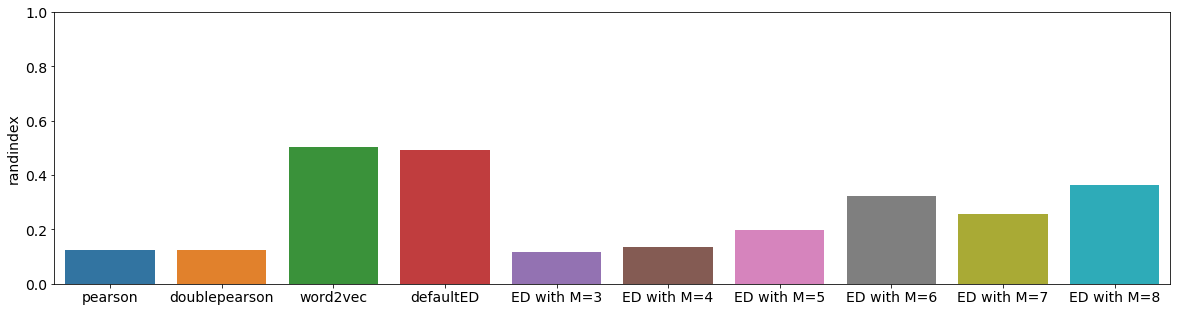

In [105]:
# df.plot(kind='bar', x='similarity', figsize=(8,5))
import seaborn as sns
sns_plot = sns.barplot(data=df, x='similarity', y='randindex')
fig = sns_plot.get_figure()
fig.set_size_inches(20,5)
sns_plot.set(ylim=(0, 1))
sns_plot.set_xlabel('')
sns_plot.set_ylabel('randindex', fontsize=14)
sns_plot.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('visualizations/seaborn/clustering_randindex-edit_distance_thresholds-%s.svg' % dataset['name'])

## Visualizing both barplots of two knowledge components in one figure

In [164]:
colors = ['blue','lightish blue','green','red']
colors.extend(['lightish red']*6)

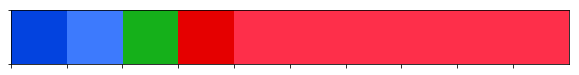

In [165]:
#https://xkcd.com/color/rgb/
sns.palplot(sns.xkcd_palette(colors))


In [166]:
colors = sns.xkcd_palette(colors)

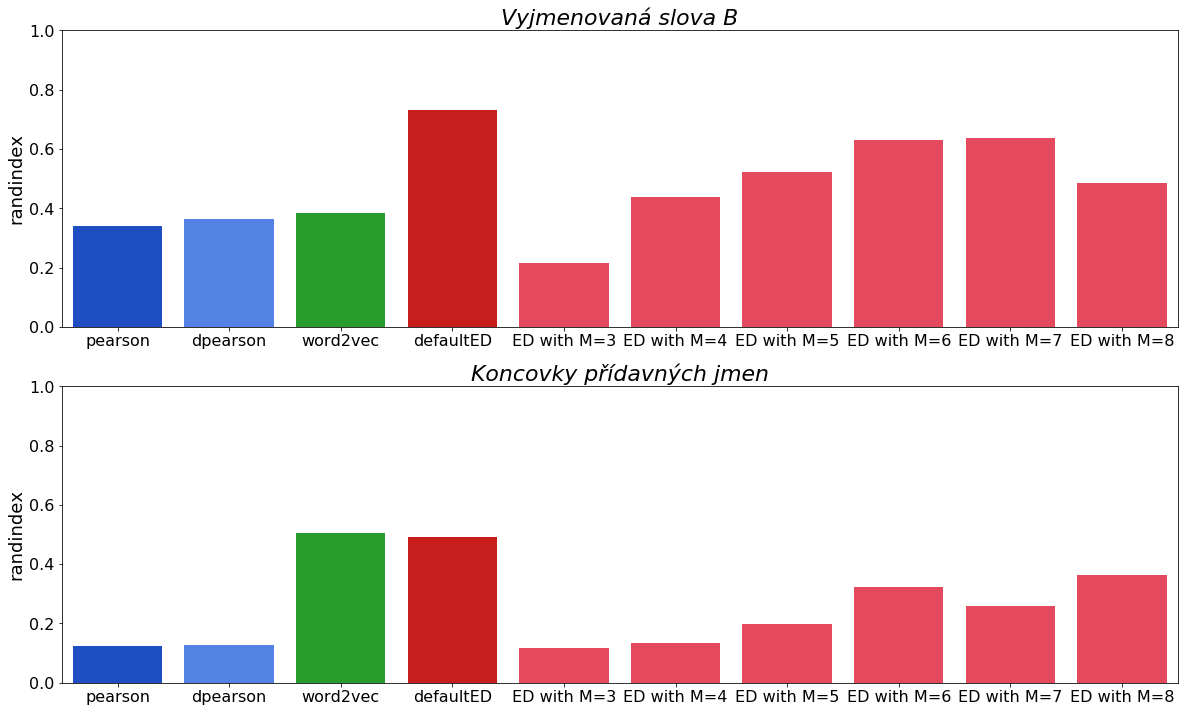

In [186]:
figure, (ax1,ax2) = plt.subplots(2,1)
figure.set_size_inches(20,12)
# colors = ['blue','orange','green','red']
# colors.extend(['indianred']*5)

a1 = sns.barplot(data=datasets[0]['randindex'], ax=ax1, x='similarity', y='randindex', palette=colors)
a1.set(ylim=(0, 1))
a1.set_xlabel('')
a1.set_ylabel('randindex', fontsize=18)
a1.tick_params(axis='both', which='major', labelsize=16)
a1.set_title('Vyjmenovaná slova B', fontsize=22, fontstyle='italic')

a2 = sns.barplot(data=datasets[1]['randindex'], ax=ax2, x='similarity', y='randindex', palette=colors)
a2.set(ylim=(0, 1))
a2.set_xlabel('')
a2.set_ylabel('randindex', fontsize=18)
a2.tick_params(axis='both', which='major', labelsize=16)
a2.set_title('Koncovky přídavných jmen', fontsize=22, fontstyle='italic')
plt.savefig('visualizations/seaborn/randindex-barplot.svg')
plt.show()

# Visualizing only labeled data

In [150]:
editdistancethreshold = create_edit_similarity_matrix(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold)
editdistance = editdistance.astype(float)

TypeError: levenshtein_similarity_with_threshold() missing 2 required positional arguments: 's1' and 's2'

In [142]:
dataset['data']['question_id'] = dataset['data'].index

In [143]:
data = dataset['data'][dataset['data']['question_id'].isin(pearson2.index)].drop_duplicates(['question_id'])

In [144]:
len(data)

66

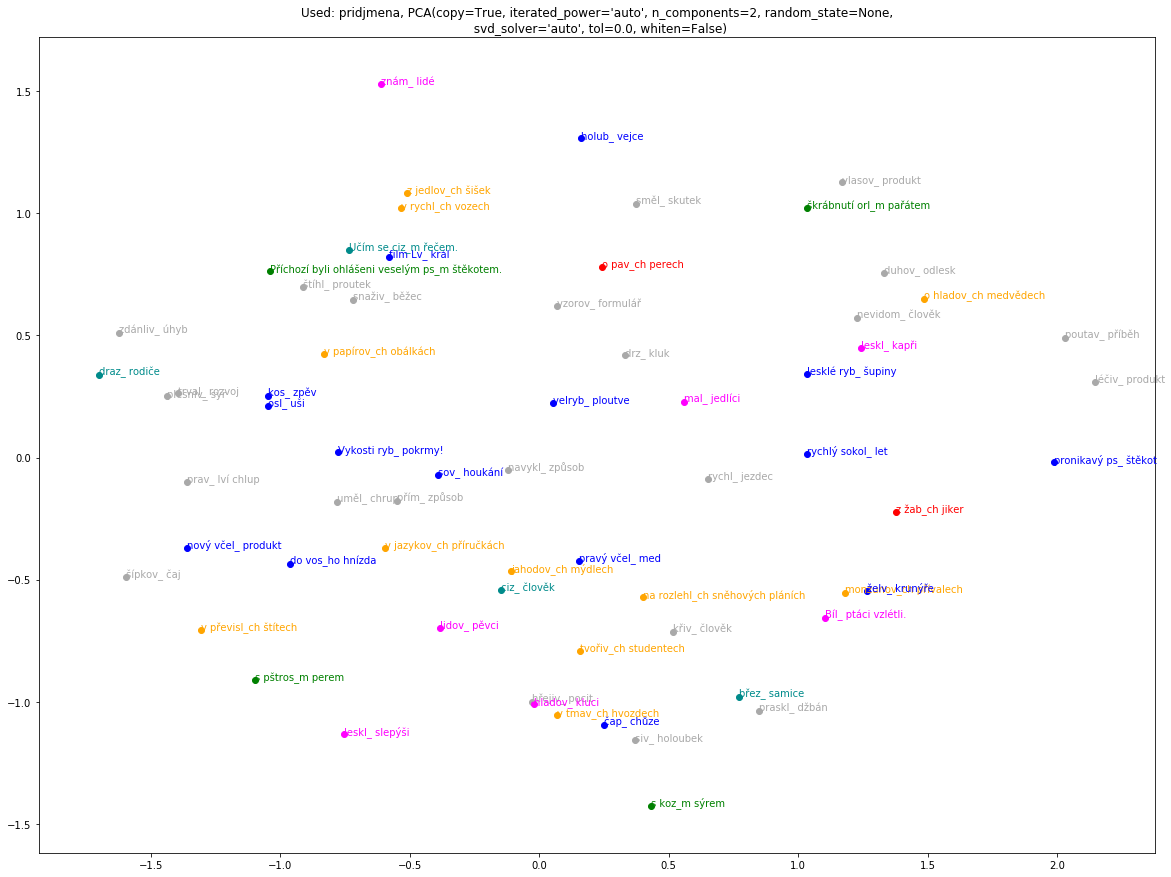

In [148]:
from sklearn.decomposition import PCA
from projections.base_projection import *
model = PCA(n_components=2)
result = model.fit_transform(pearson1)
# create a scatter plot of the projections
x_positions = result[:, 0]
y_positions = result[:, 1]

projection = Projection(x_positions, y_positions, data.copy(), data_name='pridjmena', model=model)
projection.matplotlib_plot_with_manual_labels(figsize=(20,15), save_path='visualizations/editdistance-withthreshold-vis-%s.png' % dataset['name'], annotate=True)